## 20200923-181126-network-RMSprop

In [1]:
import tensorflow as tf
import numpy as np
import sys
sys.path.append('../../')
import utils.data_preprocess as preprocess
from utils.model_metrics import ModelMetric
from utils.mode_figure import ModelFigre
import datetime
from utils.model_callback import step_decay, exp_decay, MyStopTrainCallBack

In [2]:
modelmetric = ModelMetric()

In [3]:
pre = preprocess.preprocess("D:/DataSet/CICIDS2017/CSV/Wednesday-workingHours.pcap_ISCX.csv", labelColumnName='Label', depth=2)
X_train, X_test, y_train, y_test = pre.preprocessing()

In [4]:
from tensorflow.keras import layers, Input, constraints
from tensorflow.keras import Model
dos_input = Input(shape=(X_train.shape[1],))

dense = layers.Dense(256, name='nn1', kernel_constraint=constraints.MaxNorm(max_value=4))(dos_input)
activation = layers.Activation(tf.nn.relu, name='nn1_relu')(dense)
drop = layers.GaussianDropout(0.5)(dense)
dense = layers.Dense(128, name='nn2')(drop)
activation = layers.Activation(tf.nn.relu, name='nn2_relu')(dense)
noise = layers.GaussianNoise(0.5)(activation)
dense = layers.Dense(64, name='nn3')(noise)
activation = layers.Activation(tf.nn.relu, name='nn3_relu')(dense)
noise = layers.GaussianNoise(0.5)(activation)
dense = layers.Dense(32, name='nn4')(noise)
activation = layers.Activation(tf.nn.relu, name='nn4_relu')(dense)
noise = layers.GaussianNoise(0.5)(activation)
dense = layers.Dense(16, name='nn5')(noise)
activation = layers.Activation(tf.nn.relu, name='nn5_relu')(dense)
dense = layers.Dense(8, name='nn6')(activation)
activation = layers.Activation(tf.nn.relu, name='nn6_relu')(dense)
dense = layers.Dense(2, name='nn7')(activation)
output = layers.Activation(tf.nn.softmax, name='output')(dense)


model = Model(inputs=dos_input, outputs=output)
# algorithm = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, clipvalue=0.3, momentum=0.9, epsilon=1e-07, decay= 1e-06, centered=False, name='RMSprop')
algorithm = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.99, clipvalue=0.2, nesterov=True, name='SGD')

model.compile(optimizer=algorithm, loss='binary_crossentropy', metrics=modelmetric.metric('binary_crossentropy')) # categorical_crossentropycategorical_crossentropy

In [5]:
from tensorflow.keras import callbacks
dir_name = datetime.datetime.now().strftime("ANN-%Y%m%d-%H%M%S-SGD")

logdir = os.path.join("../../tensorboard", dir_name)
tensorboard_callback = callbacks.TensorBoard(logdir, histogram_freq=1)
# lrate = callbacks.LearningRateScheduler(step_decay)
csv_log = tf.keras.callbacks.CSVLogger('../../model_record/'+dir_name+"/log", separator=',', append=False)
if not os.path.isdir('../../model_record/'+dir_name):
    os.mkdir('../../model_record/'+dir_name)
    os.mkdir('../../model_record/'+dir_name+'/model')
# stop_train = MyStopTrainCallBack()
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [6]:
import numpy as np
model_ = model.fit(X_train, y_train, epochs=100, batch_size=512, validation_split=0.3, callbacks=[tensorboard_callback, csv_log], verbose=1) # lrate

fp: 2018.0000 - val_tn: 143178.0000 - val_fn: 2018.0000 - val_acc: 0.3387 - val_precision: 0.9861 - val_recall: 0.9861 - val_auc: 0.9988 - val_binary_accuracy: 0.9861 - val_binary_crossentropy: 0.0398
Epoch 63/100
662/662 [==============================] - 7s 10ms/step - loss: 0.0412 - tp: 333899.0000 - fp: 4889.0000 - tn: 333899.0000 - fn: 4889.0000 - acc: 0.3459 - precision: 0.9856 - recall: 0.9856 - auc: 0.9988 - binary_accuracy: 0.9856 - binary_crossentropy: 0.0412 - val_loss: 0.0410 - val_tp: 143129.0000 - val_fp: 2067.0000 - val_tn: 143129.0000 - val_fn: 2067.0000 - val_acc: 0.2968 - val_precision: 0.9858 - val_recall: 0.9858 - val_auc: 0.9989 - val_binary_accuracy: 0.9858 - val_binary_crossentropy: 0.0410
Epoch 64/100
662/662 [==============================] - 7s 10ms/step - loss: 0.0413 - tp: 333866.0000 - fp: 4922.0000 - tn: 333866.0000 - fn: 4922.0000 - acc: 0.3522 - precision: 0.9855 - recall: 0.9855 - auc: 0.9988 - binary_accuracy: 0.9855 - binary_crossentropy: 0.0413 - val

In [7]:
results  = model.evaluate(X_test, y_test, verbose=1)
modelmetric.getTrainMetricValue(model, results)

6482/6482 [==============================] - 40s 6ms/step - loss: 0.0384 - tp: 204689.0000 - fp: 2733.0000 - tn: 204689.0000 - fn: 2733.0000 - acc: 0.3181 - precision: 0.9868 - recall: 0.9868 - auc: 0.9990 - binary_accuracy: 0.9868 - binary_crossentropy: 0.0384
loss :  0.03839242458343506
tp :  204689.0
fp :  2733.0
tn :  204689.0
fn :  2733.0
acc :  0.31808823347091675
precision :  0.9868239760398865
recall :  0.9868239760398865
auc :  0.9989969730377197
binary_accuracy :  0.9868239760398865
binary_crossentropy :  0.03839242458343506


In [8]:
y_pred = model.predict(X_test)
y_class = np.argmax(y_pred, axis=1)
y_label = np.argmax(y_test, axis=1)
modelmetric.confusion_matrix(y_label, y_class)
modelmetric.eva_metric(y_label, y_class)

TrueNegatives result:  128989.0
TruePositives result:  75700.0
FalseNegatives result:  117.0
FalsePositives result:  2616.0
Recall result:  0.99845684
Precision result:  0.96659684


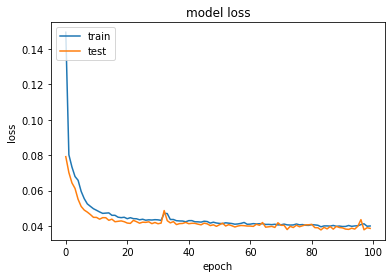

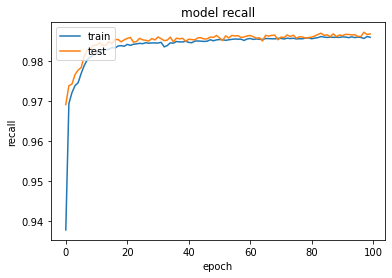

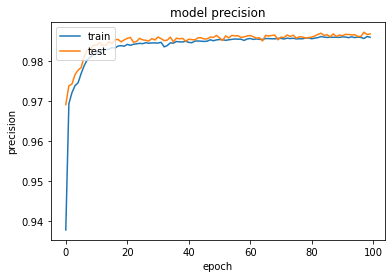

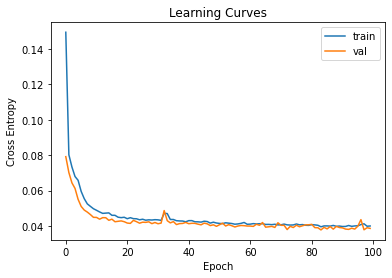

In [9]:
mf = ModelFigre("../../model_record", dir_name, model_)
mf.loss_graph()
mf.recall_graph()
mf.precision_graph()
mf.cross_entropy_graph()
# fig.save_model(net,dir_name)

In [10]:
# mf.lr_graph()

In [11]:
model.save('../../model_record/'+dir_name+'/model/model.h5')

In [12]:
# mf.save_model()